In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install -q transformers datasets sentence-transformers torch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Load pretrained SimCSE model and tokenizer
MODEL_NAME = "princeton-nlp/sup-simcse-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device)

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [7]:
# Load SNLI dataset
dataset = load_dataset("snli", split="train[:2%]")  # Using 2% of the dataset for fast training

README.md:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/412k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/413k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

In [8]:
# Custom Dataset Class for Contrastive Learning
class SimCSEDataset(Dataset):
    def __init__(self, dataset):
        self.sentences1 = [ex["premise"] for ex in dataset]
        self.sentences2 = [ex["hypothesis"] for ex in dataset]

    def __len__(self):
        return len(self.sentences1)

    def __getitem__(self, idx):
        s1 = self.sentences1[idx]
        s2 = self.sentences2[idx]
        return s1, s2

In [9]:
# Create DataLoader
train_dataset = SimCSEDataset(dataset)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [10]:
# Contrastive Loss (Cosine Similarity + NT-Xent)
def contrastive_loss(embeddings1, embeddings2, temperature=0.05):
    cos_sim = nn.functional.cosine_similarity(embeddings1, embeddings2)
    loss = -torch.mean(torch.log(torch.exp(cos_sim / temperature) / torch.sum(torch.exp(cos_sim / temperature))))
    return loss

In [11]:
# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

In [12]:
# Fine-Tuning Loop (1 Epoch)
model.train()
for epoch in range(1):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for sentences1, sentences2 in loop:
        inputs1 = tokenizer(sentences1, padding=True, truncation=True, return_tensors="pt").to(device)
        inputs2 = tokenizer(sentences2, padding=True, truncation=True, return_tensors="pt").to(device)

        embeddings1 = model(**inputs1).last_hidden_state[:, 0, :]
        embeddings2 = model(**inputs2).last_hidden_state[:, 0, :]

        loss = contrastive_loss(embeddings1, embeddings2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

# Save the fine-tuned model
model.save_pretrained("simcse-finetuned")
tokenizer.save_pretrained("simcse-finetuned")

print("Model saved successfully! ✅")

Epoch 1: 100%|██████████| 688/688 [02:06<00:00,  5.44it/s, loss=2.4] 


Model saved successfully! ✅



🔹 Cosine Similarity Scores:
I love playing football.  ↔  I love playing football.: 1.0000
I love playing football.  ↔  Soccer is my favorite sport.: 0.9993
I love playing football.  ↔  Artificial Intelligence is the future.: 0.9980
I love playing football.  ↔  I enjoy watching football games.: 0.9996
I love playing football.  ↔  Machine learning is a subset of AI.: 0.9977


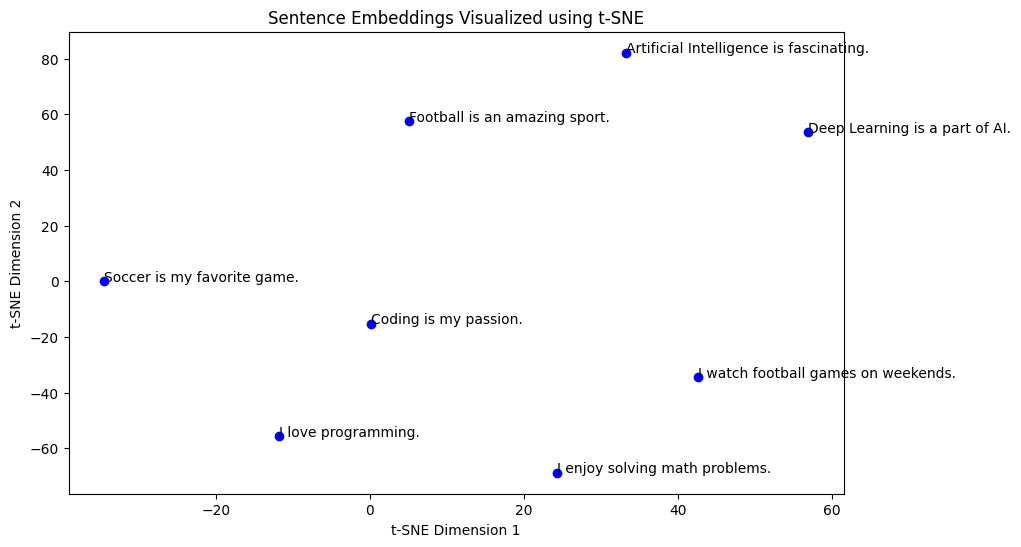

In [18]:
# Load the fine-tuned model
model_name = "simcse-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# Function to get sentence embeddings
def get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        output = model(**inputs)
    return output.last_hidden_state[:, 0, :].cpu().numpy()  # Extract CLS token

# ✅ 1️⃣ Compute Cosine Similarity for Similar Sentences
sentences = [
    "I love playing football.",
    "Soccer is my favorite sport.",
    "Artificial Intelligence is the future.",
    "I enjoy watching football games.",
    "Machine learning is a subset of AI.",
]

# Get embeddings for all sentences
embeddings = [get_embedding(sent) for sent in sentences]

embeddings = np.vstack(embeddings)
# Compute cosine similarity
# similarity_matrix = cosine_similarity(embeddings[0], embeddings)  # Compare first sentence with others
similarity_matrix = cosine_similarity(embeddings)

print("\n🔹 Cosine Similarity Scores:")
for i, sent in enumerate(sentences):
    print(f"{sentences[0]}  ↔  {sent}: {similarity_matrix[0][i]:.4f}")

# ✅ 2️⃣ Visualize Sentence Clusters Using t-SNE
sentence_list = [
    "I love programming.",
    "Coding is my passion.",
    "I enjoy solving math problems.",
    "Football is an amazing sport.",
    "Soccer is my favorite game.",
    "Artificial Intelligence is fascinating.",
    "Deep Learning is a part of AI.",
    "I watch football games on weekends."
]

# Compute embeddings
embeddings = np.vstack([get_embedding(sent) for sent in sentence_list])

# Reduce 768D embeddings to 2D
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot sentence clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color="blue")

for i, txt in enumerate(sentence_list):
    plt.annotate(txt, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.title("Sentence Embeddings Visualized using t-SNE")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

In [13]:
from transformers import AutoModel, AutoTokenizer

# Load the fine-tuned model
model_name = "simcse-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

# Encode a sentence
sentence = "Contrastive learning improves embeddings!"
inputs = tokenizer(sentence, return_tensors="pt").to(device)

with torch.no_grad():
    output = model(**inputs)
    
sentence_embedding = output.last_hidden_state[:, 0, :]
print("Embedding shape:", sentence_embedding.shape)  # (1, 768)


Embedding shape: torch.Size([1, 768])
